<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learnt patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Sat Jul 24 21:29:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and become one with the data

In [2]:
# Get data (10 % of 10 Food classes from Food101)
import zipfile

# Download the data
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-07-24 21:30:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 142.251.45.16, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   215MB/s    in 0.7s    

2021-07-24 21:30:11 (215 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}. ")

There are 2 folders and 0 images in 10_food_classes_10_percent. 
There are 10 folders and 0 images in 10_food_classes_10_percent/test. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/pizza. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/fried_rice. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/steak. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/hamburger. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/chicken_wings. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/sushi. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/chicken_curry. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/grilled_salmon. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/ice_cream. 
There are 0 folders and 250 images in 10_food_classes_10_percent/test/ramen. 
There are 10 folders and 0 images in 10_food_c

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Set up data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

# Setup the directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(directory = train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          class_mode="categorical",
                                                          batch_size = BATCH_SIZE)
print("Testing images:")
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                             target_size = IMAGE_SHAPE,
                                             class_mode = "categorical",
                                             batch_size = BATCH_SIZE)

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting nueral network paramenters). Helpful to compare the results of different models on your data.
* Model checkpoint with the ModelCheckpointing callback - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done on one sitting.
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback - Leave your model training for an arbitrary amount of time and have it stop automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [5]:
# Create TensorBoard Callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, exp_name):
  log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving tensorboard log file to: {log_dir}")
  return tensorboard_callback

**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past, we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub. 

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [9]:
# Let's make a create_model function to create a model from a URL
def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url (str): A TensorFlow Hub feature extraction URL.
  num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature extractor
  layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model


### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [10]:
# Create ResNet model
resnet_model = create_model(resnet_url,
             num_classes=train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# Compile our resnet model
resnet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [13]:
# Fit the model (ResNet Model with 10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name="Tensorboard",
                                                                          exp_name="resnet_model")])

Saving tensorboard log file to: Tensorboard/resnet_model/20210724-213142
Epoch 1/5
24/24 [==============================] - 51s 763ms/step - loss: 1.9641 - accuracy: 0.3613 - val_loss: 1.2534 - val_accuracy: 0.5872
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.8772 - accuracy: 0.7467 - val_loss: 0.8558 - val_accuracy: 0.7296
Epoch 3/5
24/24 [==============================] - 15s 657ms/step - loss: 0.6087 - accuracy: 0.8293 - val_loss: 0.7649 - val_accuracy: 0.7504
Epoch 4/5
24/24 [==============================] - 15s 653ms/step - loss: 0.4641 - accuracy: 0.8827 - val_loss: 0.7006 - val_accuracy: 0.7784
Epoch 5/5
24/24 [==============================] - 15s 661ms/step - loss: 0.3723 - accuracy: 0.9133 - val_loss: 0.6710 - val_accuracy: 0.7820


Wow!

That is incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand...(substantially) and in a quicker training time and with only 10% of the training examples.

In [14]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt
def plot_loss_curve(model_history):
  """
  Plots the Training and Validation Loss Curves
  Also plots the Training and Validation Accuracy curves

  Parameters:
  model_history: history of the model compiled and fitted
  on the training data
  """
  epochs = range(len(model_history.history["loss"]))

  training_loss = model_history.history["loss"]
  validation_loss = model_history.history["val_loss"]

  training_acc = model_history.history["accuracy"]
  validation_acc = model_history.history["val_accuracy"]

  plt.plot(epochs, training_loss, label="Training Loss")
  plt.plot(epochs, validation_loss, label="Validation Loss")
  plt.title("Training Loss curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, training_acc, label="Training Accuracy")
  plt.plot(epochs, validation_acc, label="Validation Accuracy")
  plt.title("Training Accuracy curves")
  plt.xlabel("Epochs")
  plt.legend()

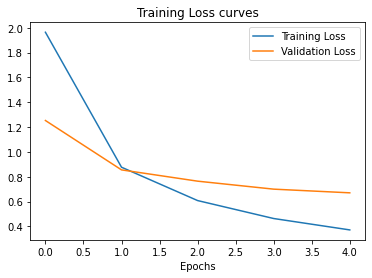

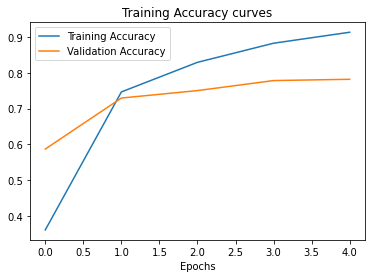

In [15]:
plot_loss_curve(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [16]:
# Create EfficientNetB0 feature extracor model
efficient_model = create_model(efficientnet_url,
                               num_classes=train_data_10_percent.num_classes)

In [17]:
# Compile the model
efficient_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [18]:
# Fit the model
efficient_history = efficient_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="Tensorboard",exp_name="effnetB050")])

Saving tensorboard log file to: Tensorboard/effnetB050/20210724-213418
Epoch 1/5
24/24 [==============================] - 25s 774ms/step - loss: 1.8368 - accuracy: 0.4293 - val_loss: 1.2837 - val_accuracy: 0.7436
Epoch 2/5
24/24 [==============================] - 16s 666ms/step - loss: 1.0482 - accuracy: 0.7733 - val_loss: 0.8458 - val_accuracy: 0.8308
Epoch 3/5
24/24 [==============================] - 16s 673ms/step - loss: 0.7379 - accuracy: 0.8440 - val_loss: 0.6808 - val_accuracy: 0.8532
Epoch 4/5
24/24 [==============================] - 15s 652ms/step - loss: 0.5928 - accuracy: 0.8787 - val_loss: 0.5959 - val_accuracy: 0.8620
Epoch 5/5
24/24 [==============================] - 15s 664ms/step - loss: 0.5005 - accuracy: 0.8973 - val_loss: 0.5448 - val_accuracy: 0.8652


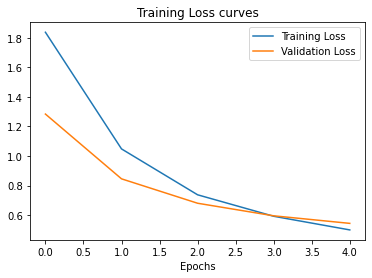

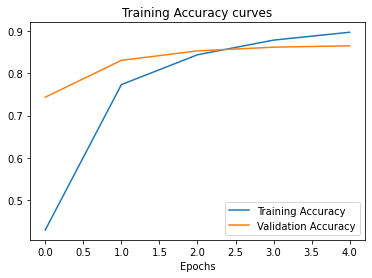

In [19]:
plot_loss_curve(efficient_history)

In [20]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no change whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **Feature Extraction" transfer learning** - use the pre-learned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes of ImageNet -> 10 classes of Food)
* **"Fine-tuning" transfer learning** - use the pre-learned patterns of an existing model and "fine-tune" many or all of the under-lying layers (including new output layers)

In [22]:
# How many layers does our efficientnetB0 feature extractor have?
len(efficient_model.layers[0].weights)

309

## Comparing our models results using TensorBoard

> **Note:** When you upload things to TensorBoard.dev, your experiments are public. So, if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./Tensorboard/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub  feature extraction model architectures using 10% of the training data" \
  --one_shot

Our tensorboard experiments are uploaded publically here: https://tensorboard.dev/experiment/gqBgqdLbQlmuXiwyGRdkkA/

In [30]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-07-24 21:13:51.713860: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/gqBgqdLbQlmuXiwyGRdkkA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub  feature extraction model architectures using 10% of the training data
	Id                   gqBgqdLbQlmuXiwyGRdkkA
	Created              2021-07-24 21:06:52 (7 minutes ago)
	Updated              2021-07-24 21:06:55 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5963064
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id xxxxxxxxxxxx